In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Challenge


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import random
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight

In [3]:
seed = 25

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Utils Functions

In [4]:
def load_data(folder="public_data.npz", resolution=96, head_only=False):
    images = []

    loaded = np.load(folder, allow_pickle=True)

    # Iterate through files in the specified folder
    for i, img in enumerate(loaded['data']):
        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        #img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        #img = tfkl.Resizing(224, 224)(img)
        img = tfkl.Resizing(resolution, resolution)(img)

        if img is not None:
            images.append(img)

        if (head_only and i == 9):
           break

    labels = loaded['labels']
    loaded.close()

    if (head_only):
       labels = labels[:10]

    y = LabelEncoder().fit_transform(labels)
    #y = tfk.utils.to_categorical(y, 2)

    return np.array(images), y

def display_random_images(X, y, num_img=10):
  # Create subplots for displaying items
  fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
  for i in range(num_img):
      image = random.randint(0, X.shape[0] - 1)

      ax = axes[i%2, i%num_img//2]
      ax.imshow(np.clip(X[image], 0, 255))  # Display clipped item images
      ax.text(0.5, -0.1, str(image) + ' ' + str(y[image]), size=12, ha="center", transform=ax.transAxes)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def delete_outliers(X, y):
  shrek = 137
  trololo = 5143

  new_X = []
  new_y = []

  num_outliers = 0

  for i, sample in enumerate(X):
    if (not (np.array_equal(sample, X[shrek]) or np.array_equal(sample, X[trololo]))):
      new_X.append(sample)
      new_y.append(y[i])
    else:
      num_outliers += 1

  return np.array(new_X), np.array(new_y), num_outliers


def plot_history(history, name, patience=20):
    plt.figure(figsize=(11,5))
    plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Val Accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_precision'], label='Val Precision', alpha=.8, color='red')
    plt.plot(history['val_recall'], label='Val Recall', alpha=.8, color='blue')
    plt.legend(loc='upper left')
    plt.title(name + ' Accuracy')
    plt.grid(alpha=.3)

    plt.text(0.5, -0.1, 'Train accuracy: ' + str(round(history['accuracy'][-patience-1], 4)) + ', Val accuracy: ' + str(round(np.max(history['val_accuracy']), 4)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.figure(figsize=(11,5))
    plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Val', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.show()

#### Data Loading end preparation

In [5]:
X, y = load_data('public_data.npz')
X, y, num_outliers = delete_outliers(X, y)

In [6]:
# Split data into train_val and test sets
X_train_0, X_val, y_train_0, y_val = train_test_split(X, y, test_size=500, stratify=y, random_state=seed)

# Further split train_val into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=500, stratify=np.argmax(y_train_val,axis=1))

print(X_train_0.shape, y_train_0.shape)
print(X_val.shape, y_val.shape)

(4504, 96, 96, 3) (4504,)
(500, 96, 96, 3) (500,)


In [7]:
def augment_dataset1(X, y):
  augment1 = tf.keras.Sequential([
      tfkl.RandomFlip(),
      tfkl.RandomTranslation(height_factor = (-0.2,0.2), width_factor = (-0.2,0.2), fill_mode = 'reflect'),
      tfkl.RandomZoom(0.3, fill_mode = 'reflect'),
      tfkl.RandomBrightness(0.1, value_range=(0,1)),
  ])

  augment2 = tf.keras.Sequential([
      tfkl.RandomFlip(),
      tfkl.RandomZoom(0.4, fill_mode = 'reflect'),
      tfkl.RandomBrightness(0.1, value_range=(0,1)),
      tfkl.RandomRotation((-1,1), fill_mode = 'reflect'),
  ])

  new_X_train_1 = augment2(X[y == 1])
  augmented_X_train_2 = augment2(X)
  augmented_X_train_1 = augment1(augmented_X_train_2)

  X = np.append(X, augmented_X_train_2, axis = 0)
  X = np.append(X, augmented_X_train_1, axis = 0)
  X = np.append(X, new_X_train_1, axis = 0)

  y_tmp = np.append(y, y)
  y = np.append(y_tmp, y)
  for k in range(new_X_train_1.shape[0]):
      y = np.append(y, 1)
  return X, y

def augment_dataset(X, y, multiply=1):
  augmentation = tf.keras.Sequential([
      tfkl.RandomRotation((-1, 1), fill_mode = 'reflect'),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tfkl.RandomBrightness((-0.3, 0.1), value_range=(0,1)),
  ])

  X_tmp = X[y == 1]
  for i in range(multiply):
    X = np.append(X, augmentation(X), axis=0)
  X = np.append(X, augmentation(X_tmp), axis=0)

  for i in range(multiply):
    y = np.append(y, y)
  y = np.append(y, np.ones(len(X_tmp)))

  return X, y

In [8]:
X_train, y_train = augment_dataset(X_train_0, y_train_0)
#X_train, y_train = X_train_0, y_train_0

#Shuffle the dataset
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model  # Output shape for the model
batch_size = 16                # Batch size for training, always a power of 2!!
epochs = 400

print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(10721, 96, 96, 3)
(10721,)
(array([0., 1.]), array([5582, 5139]))


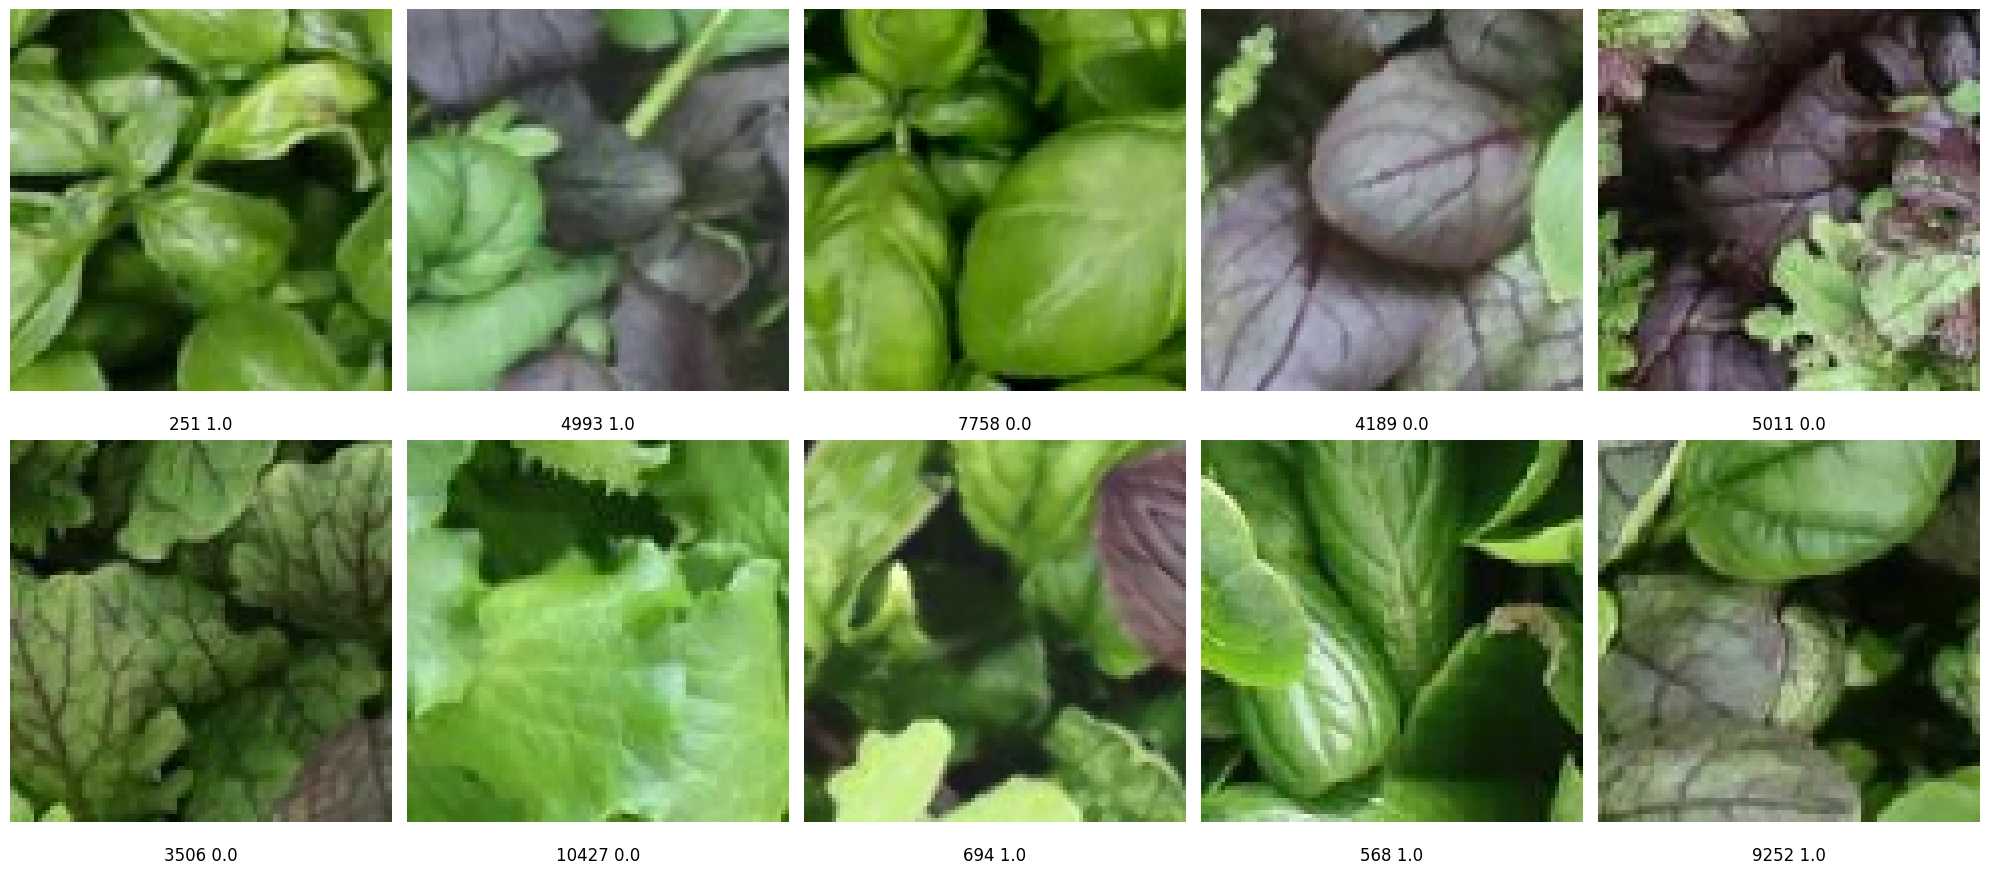

In [9]:
display_random_images(X_train, y_train)

#### Model building and validation

In [10]:
def get_block(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def build_model(input_shape, learning_rate=1e-4, neurons=[], base_dropout=0, dropout=0, batch_normalization=False, name="model", weight_decay=3e-5):
  mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
  )

  mobile.trainable = False
  inputs = tfk.Input(shape=input_shape)
  # Connect MobileNetV2 to the input
  x = mobile(inputs)
  x = tfkl.Dropout(base_dropout)(x)

  for n in neurons:
      x = get_block(x, n, batch_normalization=batch_normalization, dropout=dropout)

  # Add a Dense layer with 2 units and softmax activation as the classifier
  outputs = tfkl.Dense(1, activation='sigmoid')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=['accuracy', tfk.metrics.Precision(name="precision"), tfk.metrics.Recall(name="recall")])

  # Display model summary
  model.summary()

  return model

In [ ]:
models = [
    build_model(input_shape, learning_rate=1e-4, neurons=[128], dropout=0.5, base_dropout=0.2, batch_normalization=True),
    build_model(input_shape, learning_rate=1e-4, neurons=[256], dropout=0.5, base_dropout=0.4, batch_normalization=True),
    build_model(input_shape, learning_rate=1e-4, neurons=[64], dropout=0.3, base_dropout=0.2, batch_normalization=True),
]

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weight = {
    0: weights[0],
    1: weights[1]
}

histories = []

patience = 30

for i, model in enumerate(models):
  histories.append(model.fit(
      x = tfk.applications.mobilenet.preprocess_input(X_train * 255), # We need to apply the preprocessing thought for the MobileNetV2 network
      y = y_train,
      #class_weight = class_weight,
      batch_size = 16,
      epochs = 400,
      validation_data = (tfk.applications.mobilenet.preprocess_input(X_val * 255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 15, min_lr = 1e-5)
      ]
  ).history)

16/16 [==============================] - 1s 15ms/step
AUC: 0.8392190152801358
Best Epoch: 101


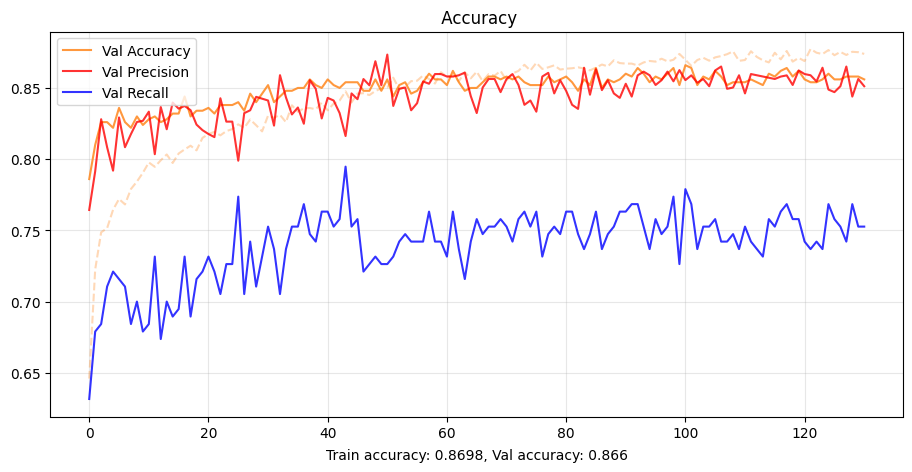

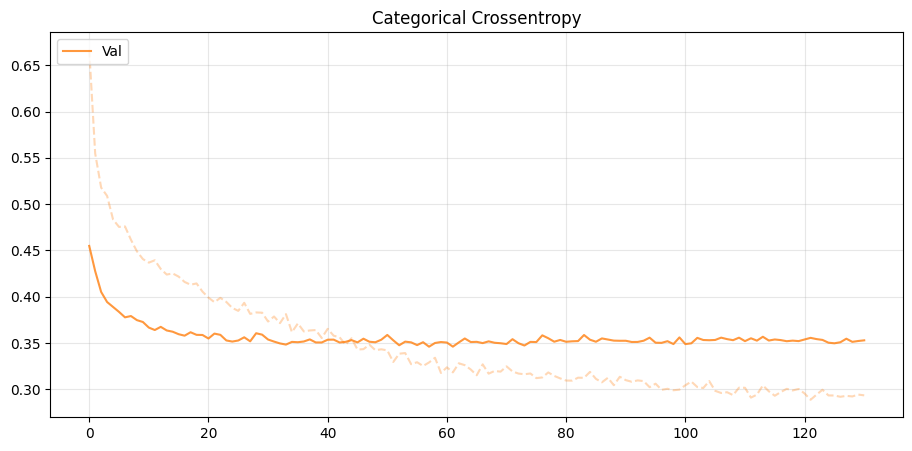

16/16 [==============================] - 0s 11ms/step
AUC: 0.8392190152801358
Best Epoch: 26


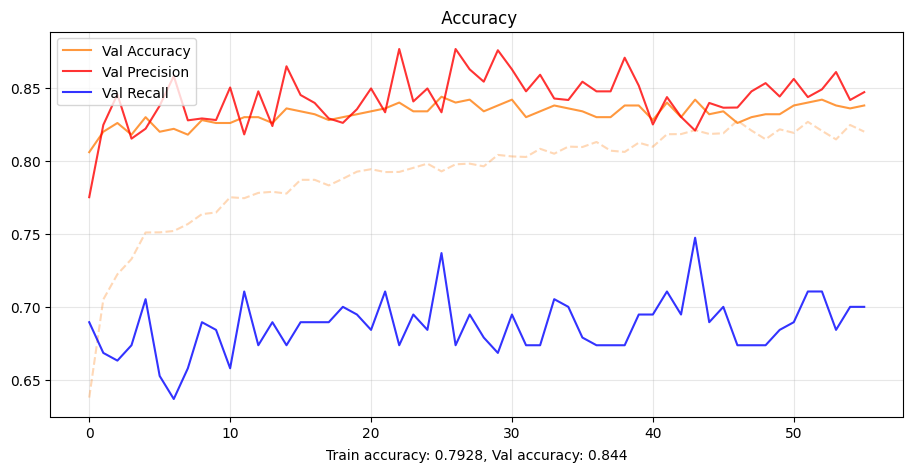

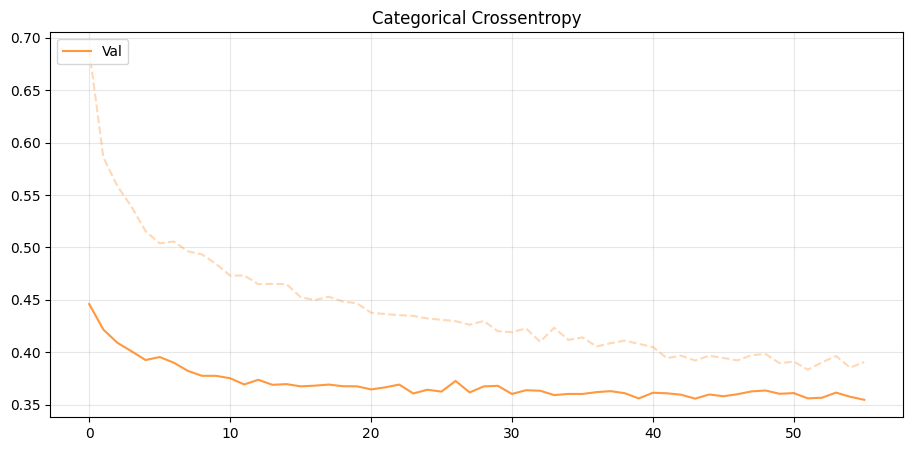

16/16 [==============================] - 0s 12ms/step
AUC: 0.8392190152801358
Best Epoch: 58


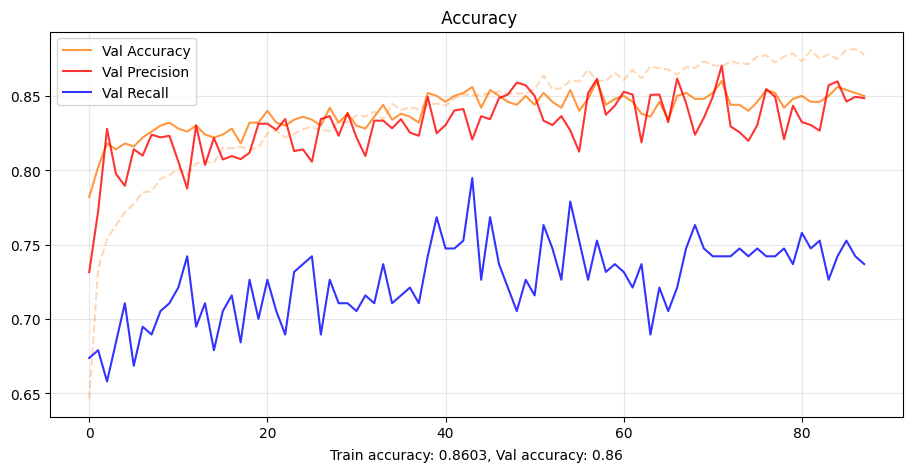

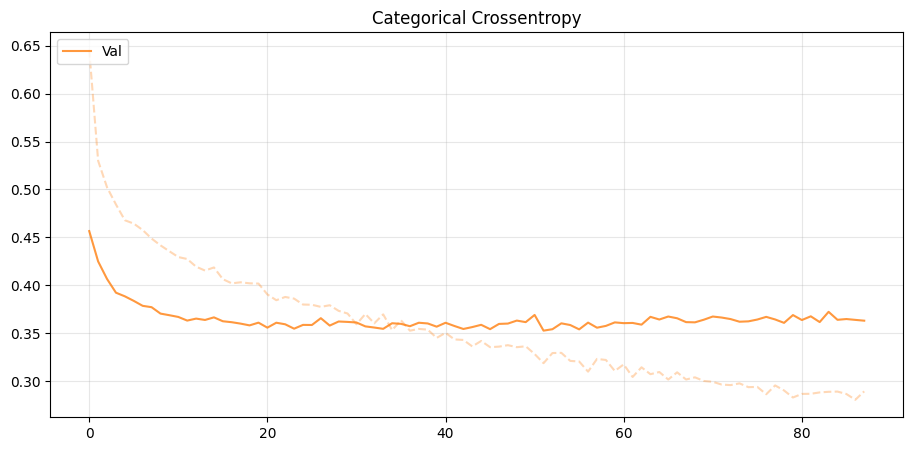

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

for history in histories:
  predictions = models[i].predict(tfk.applications.mobilenet.preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  print('AUC: ' + str(roc_auc))
  print('Best Epoch: ' + str(len(history['val_accuracy']) - patience))
  plot_history(history, patience=30, name="")

In [ ]:
# Evaluate the model on the test set
test_accuracy = model_1.evaluate(tfk.applications.mobilenet.preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8220


In [ ]:
model_1.save('Xception_NO_INVERSION_nobatchnorm')
del model_1

In [ ]:
ft_model = tfk.models.load_model('Xception_NO_INVERSION')

In [ ]:
ft_model.get_layer('xception').trainable = True
ft_model.get_layer('xception').summary()

In [ ]:
# Freeze up to last N layers
N = 7    # last block
for i, layer in enumerate(ft_model.get_layer('xception').layers[:-N]):
  layer.trainable=False

In [ ]:
for i, layer in enumerate(ft_model.get_layer('xception').layers):
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn False
add_3 False
bl

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics='accuracy')

In [ ]:
history = ft_model.fit(
    x = tfk.applications.xception.preprocess_input(X_train), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 400,
    validation_data = (tfk.applications.xception.preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.9, patience = 8, min_lr = 2e-6)
    ]
).history

Epoch 1/400
846/846 [==============================] - 45s 31ms/step - loss: 0.5213 - accuracy: 0.7436 - val_loss: 0.4153 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 2/400
846/846 [==============================] - 25s 29ms/step - loss: 0.4561 - accuracy: 0.7836 - val_loss: 0.3882 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 3/400
846/846 [==============================] - 22s 26ms/step - loss: 0.4201 - accuracy: 0.8104 - val_loss: 0.4096 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 4/400
846/846 [==============================] - 22s 26ms/step - loss: 0.3859 - accuracy: 0.8320 - val_loss: 0.5028 - val_accuracy: 0.7940 - lr: 0.0010
Epoch 5/400
846/846 [==============================] - 22s 26ms/step - loss: 0.3603 - accuracy: 0.8455 - val_loss: 0.3977 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 6/400
846/846 [==============================] - 23s 27ms/step - loss: 0.3163 - accuracy: 0.8639 - val_loss: 0.4056 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 7/400
846/846 [==============================]

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(tfk.applications.xception.preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8120


In [ ]:
ft_model.save('Xception_NO_INVERSION_finetuned')
del ft_model